# 🔬 Advanced EDA - Deep Customer Behavior Analysis

**هدف:** تحلیل‌های پیشرفته که در نوت‌بوک‌های قبلی انجام نشده

## 📋 فهرست تحلیل‌ها:

| # | تحلیل | چرا مهمه؟ |
|---|--------|----------|
| 1 | **Survival Analysis** | چه زمانی کاربران معمولاً churn می‌کنن؟ |
| 2 | **Velocity Analysis** | آیا کاربر داره کند میشه یا تند؟ |
| 3 | **Early Warning Signals** | قبل از churn چه اتفاقی میوفته؟ |
| 4 | **Recovery Analysis** | کاربرانی که برگشتن چه ویژگی‌ای دارن؟ |
| 5 | **First Order Impact** | تجربه اول چقدر مهمه؟ |
| 6 | **Segment Migration** | کاربران چطور بین سگمنت‌ها حرکت می‌کنن؟ |
| 7 | **Statistical Testing** | تفاوت‌ها واقعاً معنادارن؟ (t-test, chi-square) |
| 8 | **Delivery Tipping Point** | چند تأخیر منجر به churn میشه؟ |
| 9 | **Rating Trajectory** | آیا rating ها قبل از churn کاهش پیدا می‌کنن؟ |
| 10 | **Churner DNA** | پروفایل دقیق یک churner چیه؟ |

---

## 0️⃣ Setup & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Survival Analysis
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    from lifelines.statistics import logrank_test
    LIFELINES_AVAILABLE = True
    print('✅ lifelines installed - Survival Analysis available')
except ImportError:
    LIFELINES_AVAILABLE = False
    print('⚠️ lifelines not installed. Run: pip install lifelines')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Colors
COLORS = {
    'churned': '#e74c3c',
    'retained': '#27ae60',
    'neutral': '#3498db',
    'warning': '#f39c12'
}

print('✅ Libraries loaded')

✅ lifelines installed - Survival Analysis available
✅ Libraries loaded


## 1️⃣ Data Loading

In [2]:
DATA_DIR = '../data'

# Load data
orders_df = pd.read_csv(f'{DATA_DIR}/orders.csv')
crm_df = pd.read_csv(f'{DATA_DIR}/crm.csv')
comments_df = pd.read_csv(f'{DATA_DIR}/order_comments.csv')

# Convert dates
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

# Merge all data
master_df = orders_df.merge(crm_df, on='order_id', how='left')

# Basic info
print(f'📊 Orders: {len(orders_df):,}')
print(f'📊 Users: {orders_df["user_id"].nunique():,}')
print(f'📊 Date Range: {orders_df["order_date"].min().date()} to {orders_df["order_date"].max().date()}')

📊 Orders: 2,720,059
📊 Users: 375,998
📊 Date Range: 2025-03-16 to 2025-09-12


In [3]:
# Define Observation Date (30 days before last date)
LAST_DATE = orders_df['order_date'].max()
OBSERVATION_DATE = LAST_DATE - timedelta(days=30)
CHURN_WINDOW = 30  # days

print(f'📅 Last Date: {LAST_DATE.date()}')
print(f'📅 Observation Date: {OBSERVATION_DATE.date()}')
print(f'📅 Churn Window: {CHURN_WINDOW} days')

📅 Last Date: 2025-09-12
📅 Observation Date: 2025-08-13
📅 Churn Window: 30 days


In [4]:
master_df

,order_id,user_id,is_otd,order_date_x,delivery_status,order_date_y,crm_delivery_request_count,crm_fake_delivery_request_count,rate_to_shop,rate_to_courier
0,11169853,1385028,1,2025-03-16,delivered,2025-03-16,0,0,5.0,NaN
1,11169855,54227,1,2025-03-16,delivered,2025-03-16,0,0,4.0,NaN
2,11169857,30492532,1,2025-03-16,delivered,2025-03-16,1,0,5.0,5.0
3,11169858,2411140,1,2025-03-16,delivered,2025-03-16,0,0,NaN,NaN
4,11169859,1647659,1,2025-03-16,delivered,2025-03-16,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2720054,14995805,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN
2720055,14995807,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN
2720056,14995808,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN
2720057,14995809,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN


In [5]:
master_df.columns

Index(['order_id', 'user_id', 'is_otd', 'order_date_x', 'delivery_status',
       'order_date_y', 'crm_delivery_request_count',
       'crm_fake_delivery_request_count', 'rate_to_shop', 'rate_to_courier'],
      dtype='object')

In [6]:
# Create user-level summary
user_orders = master_df.groupby('user_id').agg(
    first_order=('order_date_x', 'min'),
    last_order=('order_date_x', 'max'),
    total_orders=('order_id', 'count'),

    avg_rate_to_shop=('rate_to_shop', 'mean'),
    avg_rate_to_courier=('rate_to_courier', 'mean'),

    late_orders=('is_otd', lambda x: (x == 0).sum()),
    on_time_orders=('is_otd', lambda x: (x == 1).sum()),
    # total_crm=('crm_count', 'sum'),
    total_crm=('crm_delivery_request_count', 'sum'),
    fake_crm=('crm_fake_delivery_request_count', 'sum')
).reset_index()

# Calculate derived features
user_orders['tenure_days'] = (user_orders['last_order'] - user_orders['first_order']).dt.days
user_orders['days_since_last'] = (OBSERVATION_DATE - user_orders['last_order']).dt.days
user_orders['is_churned'] = (user_orders['last_order'] < OBSERVATION_DATE).astype(int)
user_orders['otd_rate'] = user_orders['on_time_orders'] / user_orders['total_orders']
user_orders['late_rate'] = user_orders['late_orders'] / user_orders['total_orders']

# Only users with activity before observation
user_orders = user_orders[user_orders['first_order'] < OBSERVATION_DATE]

print(f'\n📊 Users for analysis: {len(user_orders):,}')
print(f'📊 Churn Rate: {user_orders["is_churned"].mean()*100:.1f}%')


📊 Users for analysis: 336,507
📊 Churn Rate: 64.5%


In [7]:
master_df

,order_id,user_id,is_otd,order_date_x,delivery_status,order_date_y,crm_delivery_request_count,crm_fake_delivery_request_count,rate_to_shop,rate_to_courier
0,11169853,1385028,1,2025-03-16,delivered,2025-03-16,0,0,5.0,NaN
1,11169855,54227,1,2025-03-16,delivered,2025-03-16,0,0,4.0,NaN
2,11169857,30492532,1,2025-03-16,delivered,2025-03-16,1,0,5.0,5.0
3,11169858,2411140,1,2025-03-16,delivered,2025-03-16,0,0,NaN,NaN
4,11169859,1647659,1,2025-03-16,delivered,2025-03-16,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2720054,14995805,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN
2720055,14995807,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN
2720056,14995808,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN
2720057,14995809,20524543,1,2025-09-12,delivered,2025-09-12,0,0,NaN,NaN


## 2️⃣ Survival Analysis (تحلیل بقا)

**سوال:** کاربران معمولاً چه زمانی churn می‌کنن؟

این تحلیل با cohort analysis فرق داره چون:
- Cohort: retention در هر ماه
- Survival: احتمال "زنده موندن" تا روز X

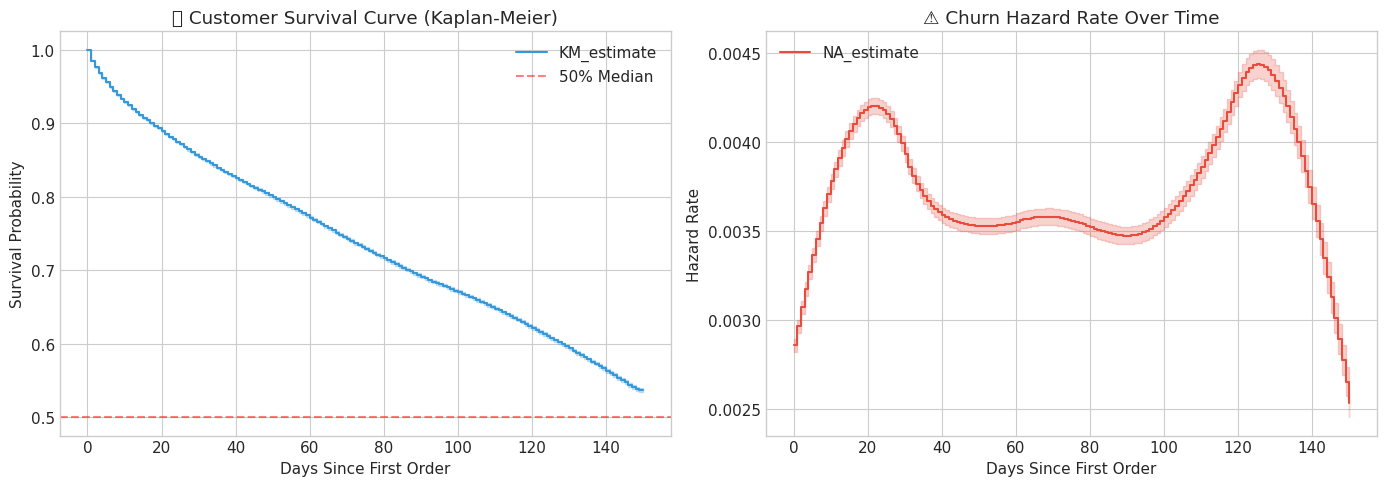


📊 Median Survival Time: inf days
📊 After 30 days, 85.4% still active
📊 After 60 days, 77.2% still active
📊 After 90 days, 69.1% still active


In [8]:
if LIFELINES_AVAILABLE:
    # Prepare survival data
    # Duration = days from first order to last order (or observation date if still active)
    survival_df = user_orders.copy()
    
    # For churned users: duration = tenure
    # For active users: duration = days from first order to observation (censored)
    survival_df['duration'] = np.where(
        survival_df['is_churned'] == 1,
        survival_df['tenure_days'],
        (OBSERVATION_DATE - survival_df['first_order']).dt.days
    )
    
    # Event = 1 if churned, 0 if censored (still active)
    survival_df['event'] = survival_df['is_churned']
    
    # Filter out duration = 0
    survival_df = survival_df[survival_df['duration'] > 0]
    
    # Kaplan-Meier Fitter
    kmf = KaplanMeierFitter()
    kmf.fit(survival_df['duration'], event_observed=survival_df['event'])
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Survival Curve
    kmf.plot_survival_function(ax=axes[0], color=COLORS['neutral'])
    axes[0].set_xlabel('Days Since First Order')
    axes[0].set_ylabel('Survival Probability')
    axes[0].set_title('🔬 Customer Survival Curve (Kaplan-Meier)')
    axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Median')
    axes[0].legend()
    
    # Hazard Rate
    # Using kernel density estimation for hazard
    from lifelines import NelsonAalenFitter
    naf = NelsonAalenFitter()
    naf.fit(survival_df['duration'], event_observed=survival_df['event'])
    naf.plot_hazard(bandwidth=30, ax=axes[1], color=COLORS['churned'])
    axes[1].set_xlabel('Days Since First Order')
    axes[1].set_ylabel('Hazard Rate')
    axes[1].set_title('⚠️ Churn Hazard Rate Over Time')
    
    plt.tight_layout()
    plt.show()
    
    # Key stats
    median_survival = kmf.median_survival_time_
    print(f'\n📊 Median Survival Time: {median_survival:.0f} days')
    print(f'📊 After 30 days, {kmf.survival_function_at_times(30).values[0]*100:.1f}% still active')
    print(f'📊 After 60 days, {kmf.survival_function_at_times(60).values[0]*100:.1f}% still active')
    print(f'📊 After 90 days, {kmf.survival_function_at_times(90).values[0]*100:.1f}% still active')
else:
    print('⚠️ Survival analysis requires lifelines library')

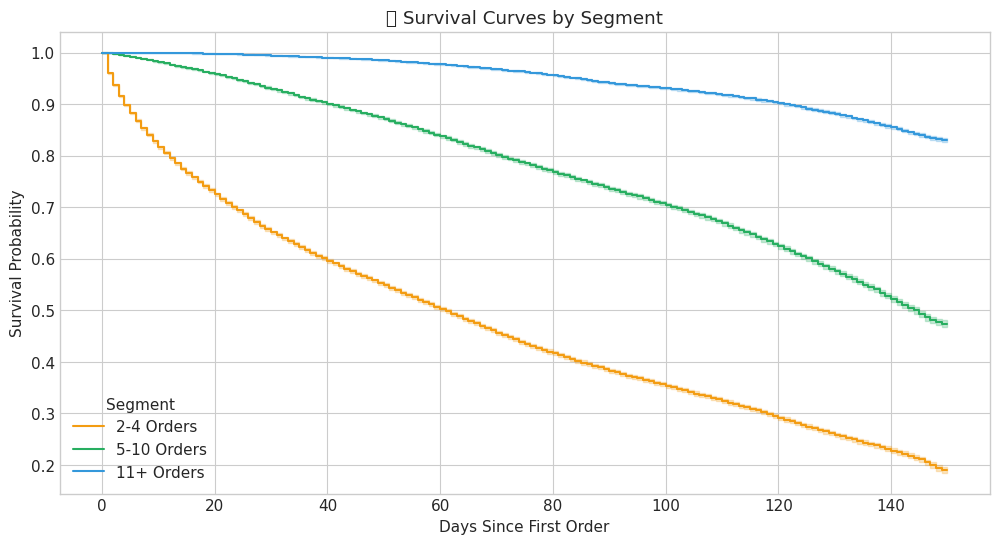


📊 Log-Rank Tests (Statistical Significance):


In [9]:
if LIFELINES_AVAILABLE:
    # Survival by order count segment
    def get_segment(n):
        if n == 1: return '1 Order'
        elif n <= 4: return '2-4 Orders'
        elif n <= 10: return '5-10 Orders'
        else: return '11+ Orders'
    
    survival_df['segment'] = survival_df['total_orders'].apply(get_segment)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#e74c3c', '#f39c12', '#27ae60', '#3498db']
    segments = ['1 Order', '2-4 Orders', '5-10 Orders', '11+ Orders']
    
    for seg, color in zip(segments, colors):
        seg_data = survival_df[survival_df['segment'] == seg]
        if len(seg_data) > 0:
            kmf = KaplanMeierFitter()
            kmf.fit(seg_data['duration'], event_observed=seg_data['event'], label=seg)
            kmf.plot_survival_function(ax=ax, color=color)
    
    ax.set_xlabel('Days Since First Order')
    ax.set_ylabel('Survival Probability')
    ax.set_title('🔬 Survival Curves by Segment')
    ax.legend(title='Segment')
    plt.show()
    
    # Log-rank test between segments
    print('\n📊 Log-Rank Tests (Statistical Significance):')
    seg1 = survival_df[survival_df['segment'] == '1 Order']
    seg2 = survival_df[survival_df['segment'] == '2-4 Orders']
    if len(seg1) > 0 and len(seg2) > 0:
        result = logrank_test(seg1['duration'], seg2['duration'], 
                             seg1['event'], seg2['event'])
        print(f'   1 Order vs 2-4 Orders: p-value = {result.p_value:.4e}')

---
## 3️⃣ Velocity Analysis (شتاب رفتار)

**سوال:** آیا کاربر داره کند میشه (احتمال churn) یا تند (engaged)?

این تحلیل avg_gap رو نگاه نمیکنه، بلکه **تغییر** در gap رو بررسی می‌کنه.

In [10]:
master_df.columns

Index(['order_id', 'user_id', 'is_otd', 'order_date_x', 'delivery_status',
       'order_date_y', 'crm_delivery_request_count',
       'crm_fake_delivery_request_count', 'rate_to_shop', 'rate_to_courier'],
      dtype='object')

In [11]:
# Calculate velocity for users with 3+ orders
# Velocity = (recent gap - early gap) / early gap
# Negative = speeding up, Positive = slowing down

def calculate_velocity(user_df):
    """Calculate purchase velocity for a user."""
    if len(user_df) < 3:
        return None
    
    user_df = user_df.sort_values('order_date_x')
    gaps = user_df['order_date_x'].diff().dt.days.dropna().values
    
    if len(gaps) < 2:
        return None
    
    # Split into early and recent gaps
    mid = len(gaps) // 2
    early_avg = np.mean(gaps[:mid])
    recent_avg = np.mean(gaps[mid:])
    
    if early_avg == 0:
        return None
    
    # Velocity: positive = slowing down, negative = speeding up
    velocity = (recent_avg - early_avg) / early_avg
    return velocity

# Only users with 3+ orders before observation
historical = master_df[master_df['order_date_x'] < OBSERVATION_DATE]
users_3plus = historical.groupby('user_id').filter(lambda x: len(x) >= 3)

velocity_df = users_3plus.groupby('user_id').apply(calculate_velocity).reset_index()
velocity_df.columns = ['user_id', 'velocity']
velocity_df = velocity_df.dropna()

# Merge with churn status
velocity_df = velocity_df.merge(user_orders[['user_id', 'is_churned']], on='user_id')

print(f'📊 Users with velocity calculated: {len(velocity_df):,}')

📊 Users with velocity calculated: 135,349


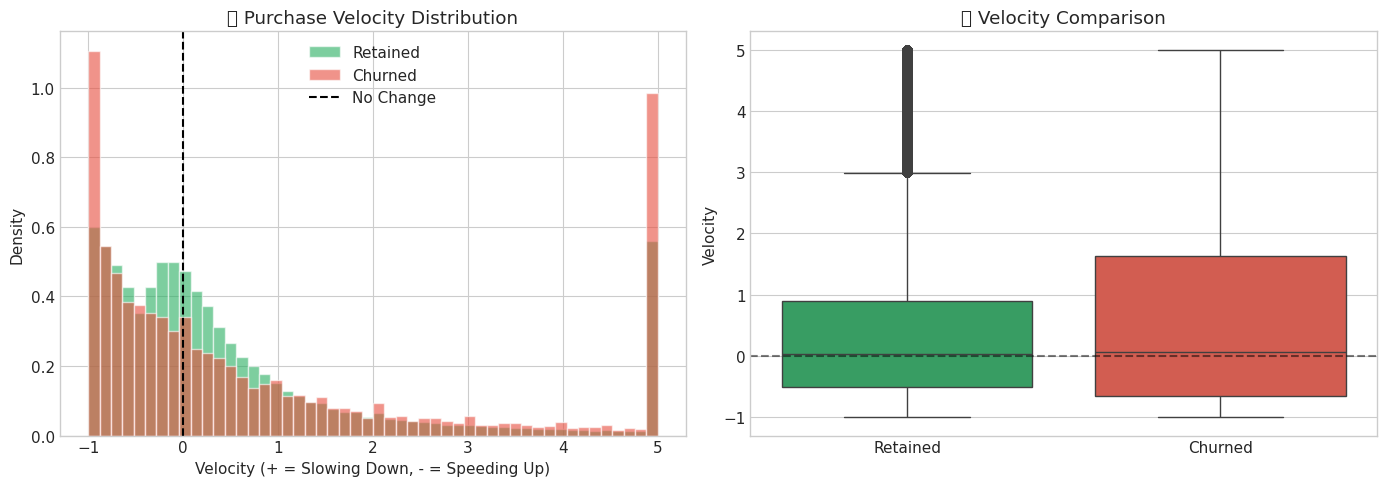


📊 Mann-Whitney U Test (Churned velocity > Retained):
   Churned median velocity: 0.06
   Retained median velocity: 0.04
   p-value: 1.0382e-04
   Significant: Yes ✅


In [12]:
# Velocity Distribution: Churned vs Retained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clip extreme velocities for visualization
velocity_df['velocity_clipped'] = velocity_df['velocity'].clip(-2, 5)

# Distribution
churned = velocity_df[velocity_df['is_churned'] == 1]['velocity_clipped']
retained = velocity_df[velocity_df['is_churned'] == 0]['velocity_clipped']

axes[0].hist(retained, bins=50, alpha=0.6, label='Retained', color=COLORS['retained'], density=True)
axes[0].hist(churned, bins=50, alpha=0.6, label='Churned', color=COLORS['churned'], density=True)
axes[0].axvline(x=0, color='black', linestyle='--', label='No Change')
axes[0].set_xlabel('Velocity (+ = Slowing Down, - = Speeding Up)')
axes[0].set_ylabel('Density')
axes[0].set_title('🏃 Purchase Velocity Distribution')
axes[0].legend()

# Box plot
velocity_df['status'] = velocity_df['is_churned'].map({0: 'Retained', 1: 'Churned'})
sns.boxplot(data=velocity_df, x='status', y='velocity_clipped', 
            palette=[COLORS['retained'], COLORS['churned']], ax=axes[1])
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('')
axes[1].set_ylabel('Velocity')
axes[1].set_title('🏃 Velocity Comparison')

plt.tight_layout()
plt.show()

# Statistical test
stat, pvalue = stats.mannwhitneyu(churned, retained, alternative='greater')
print(f'\n📊 Mann-Whitney U Test (Churned velocity > Retained):')
print(f'   Churned median velocity: {churned.median():.2f}')
print(f'   Retained median velocity: {retained.median():.2f}')
print(f'   p-value: {pvalue:.4e}')
print(f'   Significant: {"Yes ✅" if pvalue < 0.05 else "No ❌"}')

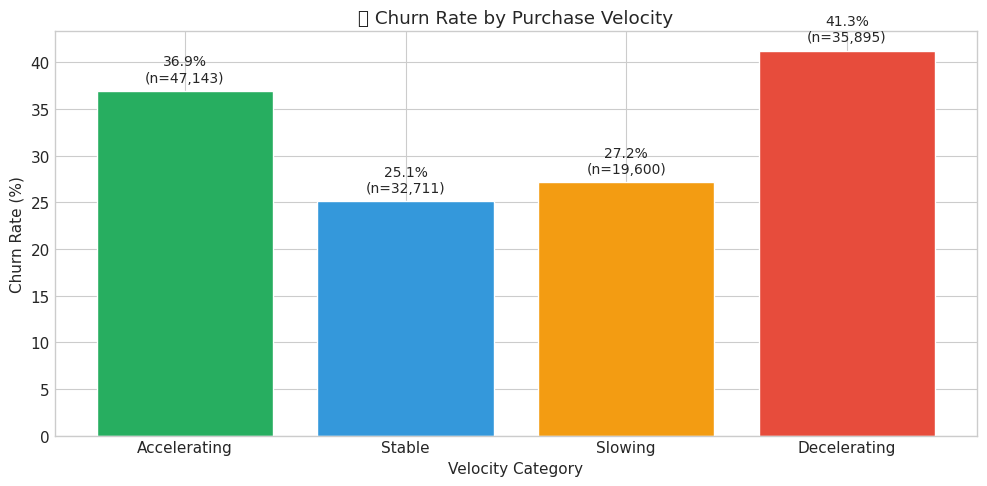


💡 Insight: کاربرانی که سرعت خریدشون کم شده، بیشتر احتمال churn دارن


In [13]:
# Velocity categories
def velocity_category(v):
    if v < -0.3: return 'Accelerating'
    elif v < 0.3: return 'Stable'
    elif v < 1.0: return 'Slowing'
    else: return 'Decelerating'

velocity_df['velocity_cat'] = velocity_df['velocity'].apply(velocity_category)

# Churn rate by velocity category
velocity_churn = velocity_df.groupby('velocity_cat').agg(
    count=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()
velocity_churn['churn_rate'] = velocity_churn['churned'] / velocity_churn['count'] * 100

# Reorder
cat_order = ['Accelerating', 'Stable', 'Slowing', 'Decelerating']
velocity_churn['velocity_cat'] = pd.Categorical(velocity_churn['velocity_cat'], categories=cat_order, ordered=True)
velocity_churn = velocity_churn.sort_values('velocity_cat')

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#27ae60', '#3498db', '#f39c12', '#e74c3c']
bars = ax.bar(velocity_churn['velocity_cat'], velocity_churn['churn_rate'], color=colors)
ax.set_xlabel('Velocity Category')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('📊 Churn Rate by Purchase Velocity')

for bar, rate, count in zip(bars, velocity_churn['churn_rate'], velocity_churn['count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{rate:.1f}%\n(n={count:,})', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print('\n💡 Insight: کاربرانی که سرعت خریدشون کم شده، بیشتر احتمال churn دارن')

---
## 4️⃣ Early Warning Signals (سیگنال‌های هشدار اولیه)

**سوال:** در آخرین سفارشات قبل از churn چه اتفاقی میوفته؟

این تحلیل به **sequence** نگاه می‌کنه نه aggregate.

In [14]:
# For churned users, look at their last N orders
# Compare with retained users' recent orders

def get_last_n_orders(df, user_id, n=5):
    """Get last n orders for a user."""
    user_df = df[df['user_id'] == user_id].sort_values('v', ascending=False).head(n)
    return user_df

# Get churned and retained users with 5+ orders
historical = master_df[master_df['order_date_x'] < OBSERVATION_DATE]
users_5plus = historical.groupby('user_id').filter(lambda x: len(x) >= 5)

churned_users = user_orders[user_orders['is_churned'] == 1]['user_id'].values
retained_users = user_orders[user_orders['is_churned'] == 0]['user_id'].values

# Get users that are in both 5plus and our classification
valid_users = users_5plus['user_id'].unique()
churned_valid = [u for u in churned_users if u in valid_users]
retained_valid = [u for u in retained_users if u in valid_users]

print(f'📊 Churned users with 5+ orders: {len(churned_valid):,}')
print(f'📊 Retained users with 5+ orders: {len(retained_valid):,}')

📊 Churned users with 5+ orders: 28,498
📊 Retained users with 5+ orders: 75,602


In [15]:
# Analyze last 5 orders metrics
def analyze_last_orders(df, user_ids, n=5):
    """Analyze metrics in last n orders."""
    results = []
    
    for user_id in user_ids:
        user_df = df[df['user_id'] == user_id].sort_values('order_date_x', ascending=False).head(n)
        user_df = user_df.sort_values('order_date_x')  # Oldest to newest
        
        if len(user_df) < n:
            continue
        
        # Calculate metrics for each position
        for i, (_, row) in enumerate(user_df.iterrows()):
            position = i - n + 1  # -4, -3, -2, -1, 0 (0 = last order)
            results.append({
                'user_id': user_id,
                'position': position,
                'is_late': 1 if row.get('is_otd', 1) == 0 else 0,
                'rate_to_shop': row.get('rate_to_shop', np.nan),
                'had_crm': 1 if row.get('crm_delivery_request_count', 0) > 0 else 0
            })
    
    return pd.DataFrame(results)

# Sample if too many users
sample_size = min(5000, len(churned_valid), len(retained_valid))
churned_sample = np.random.choice(churned_valid, size=min(sample_size, len(churned_valid)), replace=False)
retained_sample = np.random.choice(retained_valid, size=min(sample_size, len(retained_valid)), replace=False)

print('Analyzing churned users...')
churned_last = analyze_last_orders(historical, churned_sample)
churned_last['status'] = 'Churned'

print('Analyzing retained users...')
retained_last = analyze_last_orders(historical, retained_sample)
retained_last['status'] = 'Retained'

last_orders_df = pd.concat([churned_last, retained_last])
print(f'\n✅ Analysis complete: {len(last_orders_df):,} order-positions')

Analyzing churned users...
Analyzing retained users...

✅ Analysis complete: 50,000 order-positions


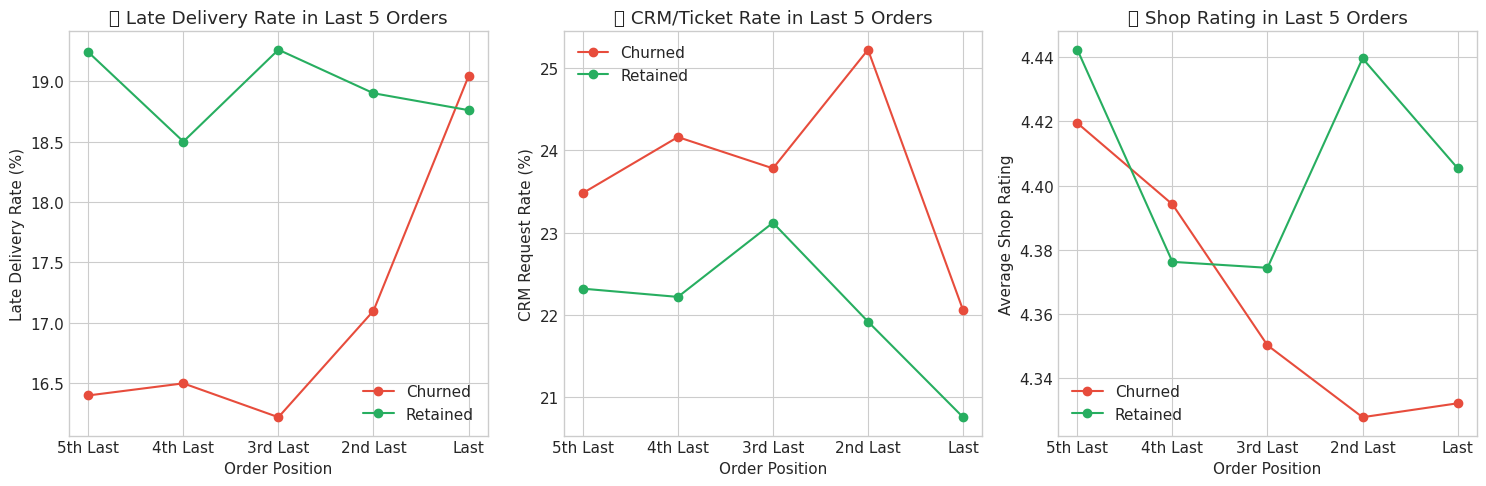


💡 Insights:
   - اگه Late Delivery برای Churners در سفارش آخر بالاست = تجربه آخر مهمه
   - اگه روند صعودی در CRM هست = مشکلات تجمعی
   - اگه Rating کاهش یافته = نارضایتی تدریجی


In [16]:
# Plot: Late delivery rate in last 5 orders
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

position_labels = {-4: '5th Last', -3: '4th Last', -2: '3rd Last', -1: '2nd Last', 0: 'Last'}

# 1. Late Delivery Rate
late_by_position = last_orders_df.groupby(['position', 'status'])['is_late'].mean().unstack() * 100
late_by_position.plot(kind='line', marker='o', ax=axes[0], 
                      color=[COLORS['churned'], COLORS['retained']])
axes[0].set_xlabel('Order Position')
axes[0].set_ylabel('Late Delivery Rate (%)')
axes[0].set_title('⏰ Late Delivery Rate in Last 5 Orders')
axes[0].set_xticks(range(-4, 1))
axes[0].set_xticklabels([position_labels[i] for i in range(-4, 1)])
axes[0].legend(title='')

# 2. CRM Request Rate
crm_by_position = last_orders_df.groupby(['position', 'status'])['had_crm'].mean().unstack() * 100
crm_by_position.plot(kind='line', marker='o', ax=axes[1],
                     color=[COLORS['churned'], COLORS['retained']])
axes[1].set_xlabel('Order Position')
axes[1].set_ylabel('CRM Request Rate (%)')
axes[1].set_title('🎫 CRM/Ticket Rate in Last 5 Orders')
axes[1].set_xticks(range(-4, 1))
axes[1].set_xticklabels([position_labels[i] for i in range(-4, 1)])
axes[1].legend(title='')

# 3. Average Rating
rating_by_position = last_orders_df.groupby(['position', 'status'])['rate_to_shop'].mean().unstack()
rating_by_position.plot(kind='line', marker='o', ax=axes[2],
                        color=[COLORS['churned'], COLORS['retained']])
axes[2].set_xlabel('Order Position')
axes[2].set_ylabel('Average Shop Rating')
axes[2].set_title('⭐ Shop Rating in Last 5 Orders')
axes[2].set_xticks(range(-4, 1))
axes[2].set_xticklabels([position_labels[i] for i in range(-4, 1)])
axes[2].legend(title='')

plt.tight_layout()
plt.show()

print('\n💡 Insights:')
print('   - اگه Late Delivery برای Churners در سفارش آخر بالاست = تجربه آخر مهمه')
print('   - اگه روند صعودی در CRM هست = مشکلات تجمعی')
print('   - اگه Rating کاهش یافته = نارضایتی تدریجی')

---
## 5️⃣ Recovery Analysis (تحلیل بازگشت)

**سوال:** کاربرانی که بعد از یه دوره غیبت برگشتن، چه ویژگی‌ای دارن؟

In [17]:
# Find users who had a long gap (30+ days) but returned
# Compare with users who didn't return

# Calculate max gap for each user
def get_max_gap(user_df):
    if len(user_df) < 2:
        return None
    user_df = user_df.sort_values('order_date_x')
    gaps = user_df['order_date_x'].diff().dt.days
    return gaps.max()

user_max_gap = historical.groupby('user_id').apply(get_max_gap).reset_index()
user_max_gap.columns = ['user_id', 'max_gap']
user_max_gap = user_max_gap.dropna()

# Merge with churn status and order count
user_max_gap = user_max_gap.merge(user_orders[['user_id', 'is_churned', 'total_orders']], on='user_id')

# Recovered = had a 30+ day gap but has 2+ orders after (not churned)
user_max_gap['had_long_gap'] = (user_max_gap['max_gap'] >= 30).astype(int)
user_max_gap['recovered'] = ((user_max_gap['had_long_gap'] == 1) & 
                              (user_max_gap['is_churned'] == 0) &
                              (user_max_gap['total_orders'] >= 3)).astype(int)

print(f'📊 Users with 30+ day gap: {user_max_gap["had_long_gap"].sum():,}')
print(f'📊 Recovered users: {user_max_gap["recovered"].sum():,}')
print(f'📊 Recovery rate among gap users: {user_max_gap[user_max_gap["had_long_gap"]==1]["recovered"].mean()*100:.1f}%')

📊 Users with 30+ day gap: 98,995
📊 Recovered users: 64,602
📊 Recovery rate among gap users: 65.3%


📊 Comparison: Recovered vs Not Recovered
                  Not Recovered  Recovered  Difference
total_orders               5.83      14.62        8.79
otd_rate                   0.74       0.74       -0.01
avg_rate_to_shop           4.26       4.23       -0.03
total_crm                  2.19       5.03        2.84
max_gap                   57.97      55.54       -2.42


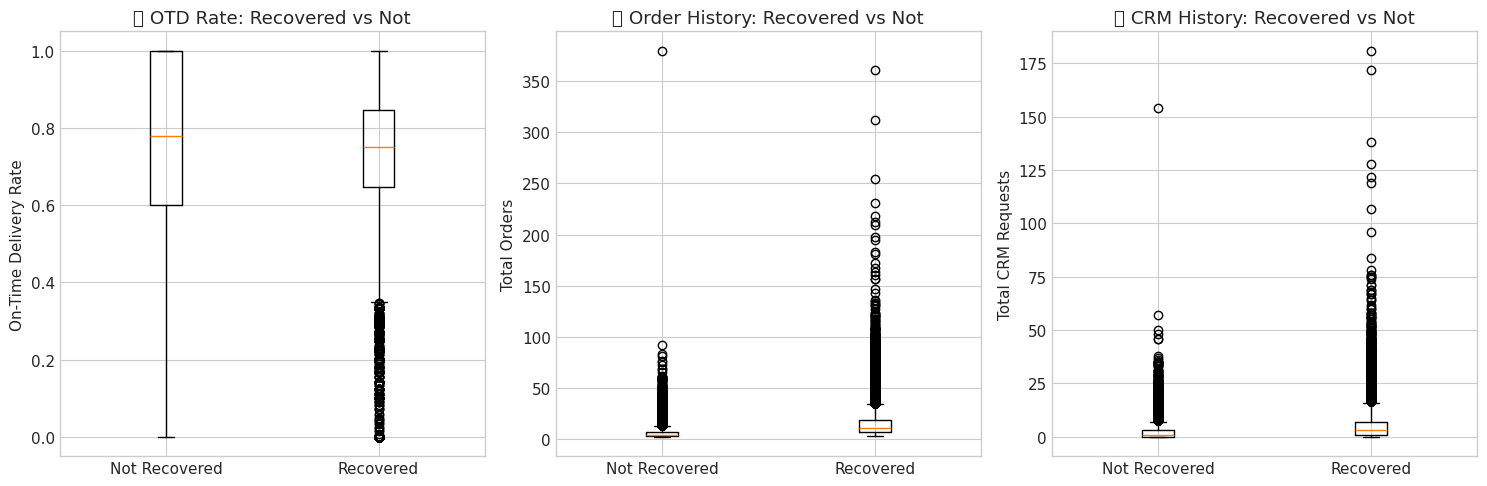


💡 Insight: کاربرانی که سابقه خرید بیشتر و تجربه بهتری داشتن، بیشتر برمیگردن


In [18]:
# What predicts recovery?
# Get features for users with long gaps
gap_users = user_max_gap[user_max_gap['had_long_gap'] == 1].copy()
gap_users = gap_users.merge(user_orders[['user_id', 'otd_rate', 'late_rate', 'avg_rate_to_shop', 'total_crm']], on='user_id')

# Compare recovered vs not recovered
comparison_cols = ['total_orders', 'otd_rate', 'avg_rate_to_shop', 'total_crm', 'max_gap']

recovery_comparison = gap_users.groupby('recovered')[comparison_cols].mean().T
recovery_comparison.columns = ['Not Recovered', 'Recovered']
recovery_comparison['Difference'] = recovery_comparison['Recovered'] - recovery_comparison['Not Recovered']

print('📊 Comparison: Recovered vs Not Recovered')
print(recovery_comparison.round(2))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# OTD Rate
recovered = gap_users[gap_users['recovered'] == 1]['otd_rate']
not_recovered = gap_users[gap_users['recovered'] == 0]['otd_rate']

axes[0].boxplot([not_recovered.dropna(), recovered.dropna()], labels=['Not Recovered', 'Recovered'])
axes[0].set_ylabel('On-Time Delivery Rate')
axes[0].set_title('📦 OTD Rate: Recovered vs Not')

# Total Orders (before gap)
axes[1].boxplot([gap_users[gap_users['recovered'] == 0]['total_orders'],
                 gap_users[gap_users['recovered'] == 1]['total_orders']], 
                labels=['Not Recovered', 'Recovered'])
axes[1].set_ylabel('Total Orders')
axes[1].set_title('🛒 Order History: Recovered vs Not')

# CRM Requests
axes[2].boxplot([gap_users[gap_users['recovered'] == 0]['total_crm'],
                 gap_users[gap_users['recovered'] == 1]['total_crm']], 
                labels=['Not Recovered', 'Recovered'])
axes[2].set_ylabel('Total CRM Requests')
axes[2].set_title('🎫 CRM History: Recovered vs Not')

plt.tight_layout()
plt.show()

print('\n💡 Insight: کاربرانی که سابقه خرید بیشتر و تجربه بهتری داشتن، بیشتر برمیگردن')

---
## 6️⃣ First Order Impact (تأثیر سفارش اول)

**سوال:** تجربه اولین سفارش چقدر روی رفتار آینده تأثیر داره؟

In [19]:
# Get first order for each user
first_orders = historical.sort_values('order_date_x').groupby('user_id').first().reset_index()

# Define first order experience
first_orders['first_was_late'] = (first_orders['is_otd'] == 0).astype(int)
first_orders['first_had_crm'] = (first_orders['crm_delivery_request_count'] > 0).astype(int)
first_orders['first_low_rating'] = (first_orders['rate_to_shop'] < 3).astype(int)

# Merge with churn status
first_orders = first_orders.merge(
    user_orders[['user_id', 'is_churned', 'total_orders']], 
    on='user_id'
)

print(f'📊 Users analyzed: {len(first_orders):,}')
print(f'📊 First order was late: {first_orders["first_was_late"].mean()*100:.1f}%')
print(f'📊 First order had CRM: {first_orders["first_had_crm"].mean()*100:.1f}%')

📊 Users analyzed: 336,507
📊 First order was late: 16.1%
📊 First order had CRM: 19.1%


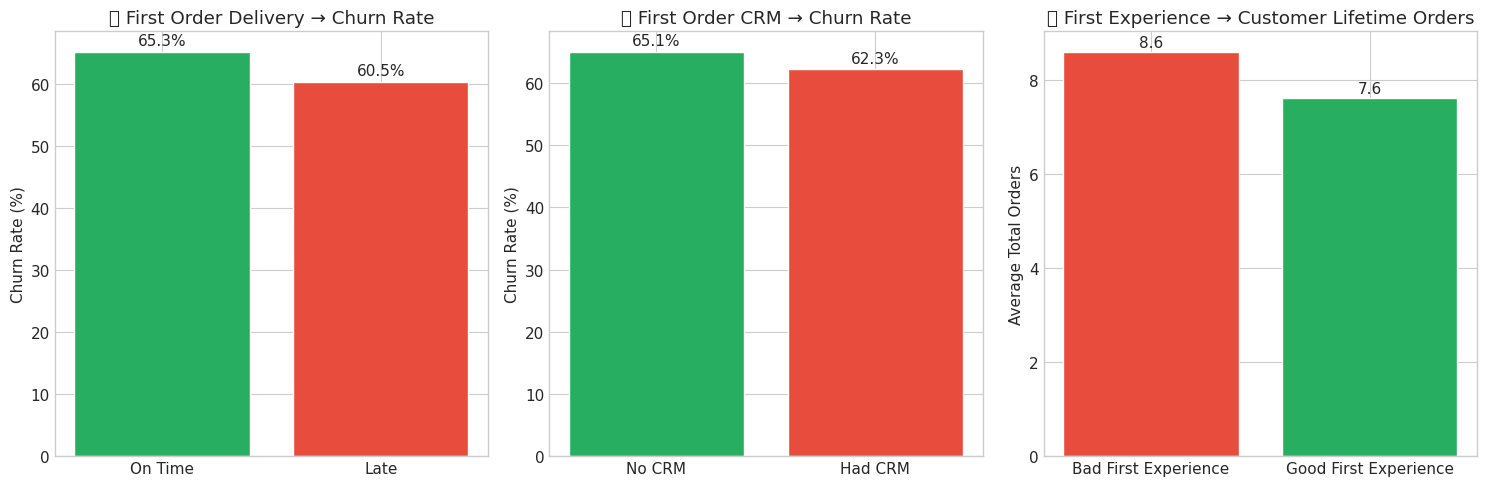


📊 Chi-Square Test (First Experience vs Churn):
   Chi-square statistic: 465.20
   p-value: 3.5512e-103
   Significant: Yes ✅


In [20]:
# Impact analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Churn Rate by First Order OTD
otd_churn = first_orders.groupby('first_was_late')['is_churned'].mean() * 100
bars1 = axes[0].bar(['On Time', 'Late'], [otd_churn[0], otd_churn[1]], 
                    color=[COLORS['retained'], COLORS['churned']])
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_title('📦 First Order Delivery → Churn Rate')
for bar, val in zip(bars1, [otd_churn[0], otd_churn[1]]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}%', ha='center')

# 2. Churn Rate by First Order CRM
crm_churn = first_orders.groupby('first_had_crm')['is_churned'].mean() * 100
bars2 = axes[1].bar(['No CRM', 'Had CRM'], [crm_churn[0], crm_churn[1]], 
                    color=[COLORS['retained'], COLORS['churned']])
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_title('🎫 First Order CRM → Churn Rate')
for bar, val in zip(bars2, [crm_churn[0], crm_churn[1]]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}%', ha='center')

# 3. Average Total Orders by First Experience
first_orders['first_experience'] = 'Good'
first_orders.loc[(first_orders['first_was_late'] == 1) | 
                 (first_orders['first_had_crm'] == 1), 'first_experience'] = 'Bad'

exp_orders = first_orders.groupby('first_experience')['total_orders'].mean()
bars3 = axes[2].bar(['Bad First Experience', 'Good First Experience'], 
                    [exp_orders.get('Bad', 0), exp_orders.get('Good', 0)],
                    color=[COLORS['churned'], COLORS['retained']])
axes[2].set_ylabel('Average Total Orders')
axes[2].set_title('📊 First Experience → Customer Lifetime Orders')
for bar, val in zip(bars3, [exp_orders.get('Bad', 0), exp_orders.get('Good', 0)]):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{val:.1f}', ha='center')

plt.tight_layout()
plt.show()

# Statistical test
good_exp = first_orders[first_orders['first_experience'] == 'Good']['is_churned']
bad_exp = first_orders[first_orders['first_experience'] == 'Bad']['is_churned']

stat, pvalue = stats.chi2_contingency(pd.crosstab(
    first_orders['first_experience'], 
    first_orders['is_churned']
))[:2]

print(f'\n📊 Chi-Square Test (First Experience vs Churn):')
print(f'   Chi-square statistic: {stat:.2f}')
print(f'   p-value: {pvalue:.4e}')
print(f'   Significant: {"Yes ✅" if pvalue < 0.05 else "No ❌"}')

---
## 7️⃣ Segment Migration Analysis (مهاجرت بین سگمنت‌ها)

**سوال:** کاربران چطور بین سگمنت‌های مختلف حرکت می‌کنن؟

In [21]:
# Define time periods for migration analysis
PERIOD_1_END = OBSERVATION_DATE - timedelta(days=60)  # 60 days before
PERIOD_2_END = OBSERVATION_DATE  # Now

# Get users with orders in both periods
period1 = historical[historical['order_date_x'] <= PERIOD_1_END]
period2 = historical[(historical['order_date_x'] > PERIOD_1_END) &
                     (historical['order_date_x'] <= PERIOD_2_END)]

# Count orders per user in each period
p1_counts = period1.groupby('user_id').size().reset_index(name='p1_orders')
p2_counts = period2.groupby('user_id').size().reset_index(name='p2_orders')

# Users with orders in both periods
migration_df = p1_counts.merge(p2_counts, on='user_id', how='outer').fillna(0)
migration_df['p1_orders'] = migration_df['p1_orders'].astype(int)
migration_df['p2_orders'] = migration_df['p2_orders'].astype(int)

# Define activity segments
def activity_segment(orders):
    if orders == 0: return 'Inactive'
    elif orders <= 2: return 'Low'
    elif orders <= 5: return 'Medium'
    else: return 'High'

migration_df['p1_segment'] = migration_df['p1_orders'].apply(activity_segment)
migration_df['p2_segment'] = migration_df['p2_orders'].apply(activity_segment)

print(f'📊 Users for migration analysis: {len(migration_df):,}')

📊 Users for migration analysis: 336,507


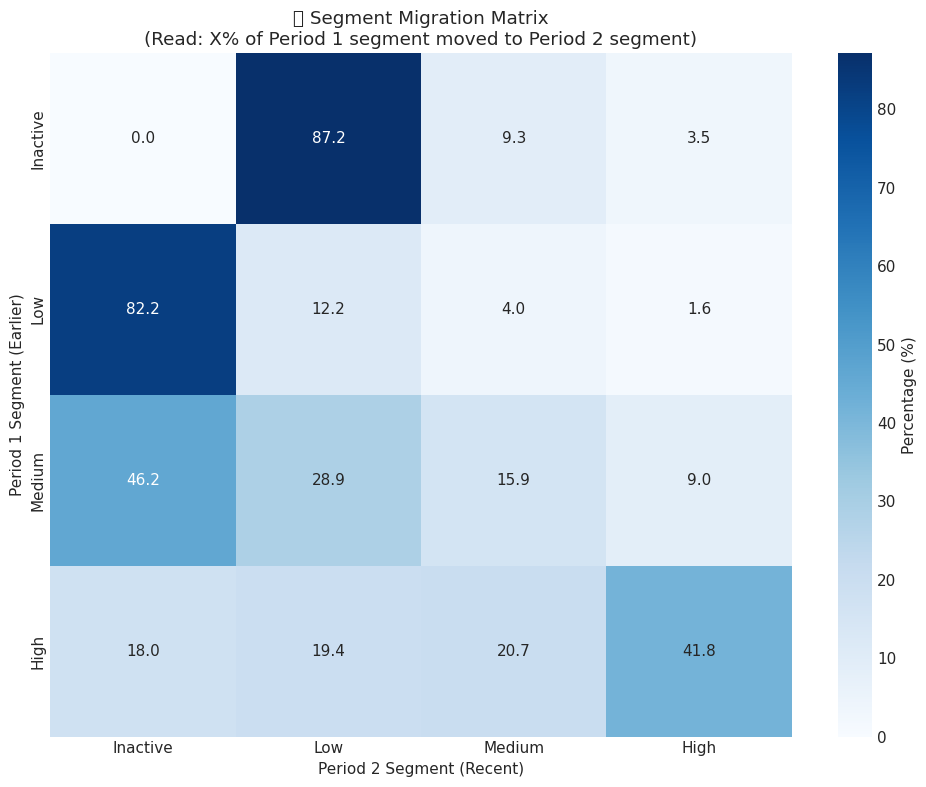


📊 Key Migration Patterns:
   Inactive: 0.0% stayed, 0.0% became inactive
   Low: 12.2% stayed, 82.2% became inactive
   Medium: 15.9% stayed, 46.2% became inactive
   High: 41.8% stayed, 18.0% became inactive


In [22]:
# Create migration matrix
segment_order = ['Inactive', 'Low', 'Medium', 'High']
migration_matrix = pd.crosstab(
    migration_df['p1_segment'], 
    migration_df['p2_segment'],
    normalize='index'
) * 100

# Reorder
migration_matrix = migration_matrix.reindex(index=segment_order, columns=segment_order, fill_value=0)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(migration_matrix, annot=True, fmt='.1f', cmap='Blues', 
            cbar_kws={'label': 'Percentage (%)'}, ax=ax)
ax.set_xlabel('Period 2 Segment (Recent)')
ax.set_ylabel('Period 1 Segment (Earlier)')
ax.set_title('📊 Segment Migration Matrix\n(Read: X% of Period 1 segment moved to Period 2 segment)')

plt.tight_layout()
plt.show()

# Key insights
print('\n📊 Key Migration Patterns:')
for seg in segment_order:
    if seg in migration_matrix.index:
        to_inactive = migration_matrix.loc[seg, 'Inactive'] if 'Inactive' in migration_matrix.columns else 0
        stayed = migration_matrix.loc[seg, seg] if seg in migration_matrix.columns else 0
        print(f'   {seg}: {stayed:.1f}% stayed, {to_inactive:.1f}% became inactive')

---
## 8️⃣ Delivery Tipping Point (نقطه شکست)

**سوال:** چند تأخیر منجر به churn میشه؟ آیا یه "تحمل" مشخصی وجود داره؟

In [23]:
# Get late count for each user
late_counts = historical.groupby('user_id').agg(
    total_orders=('order_id', 'count'),
    late_orders=('is_otd', lambda x: (x == 0).sum())
).reset_index()

late_counts = late_counts.merge(user_orders[['user_id', 'is_churned']], on='user_id')

# Calculate late percentage
late_counts['late_pct'] = late_counts['late_orders'] / late_counts['total_orders'] * 100

# Group by late count and calculate churn rate
late_churn = late_counts.groupby('late_orders').agg(
    count=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()
late_churn['churn_rate'] = late_churn['churned'] / late_churn['count'] * 100

# Filter for meaningful sample sizes
late_churn_filtered = late_churn[late_churn['count'] >= 50]

print(f'📊 Distribution of late delivery counts:')
print(late_counts['late_orders'].describe())

📊 Distribution of late delivery counts:
count    336507.000000
mean          1.079713
std           2.348814
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         144.000000
Name: late_orders, dtype: float64


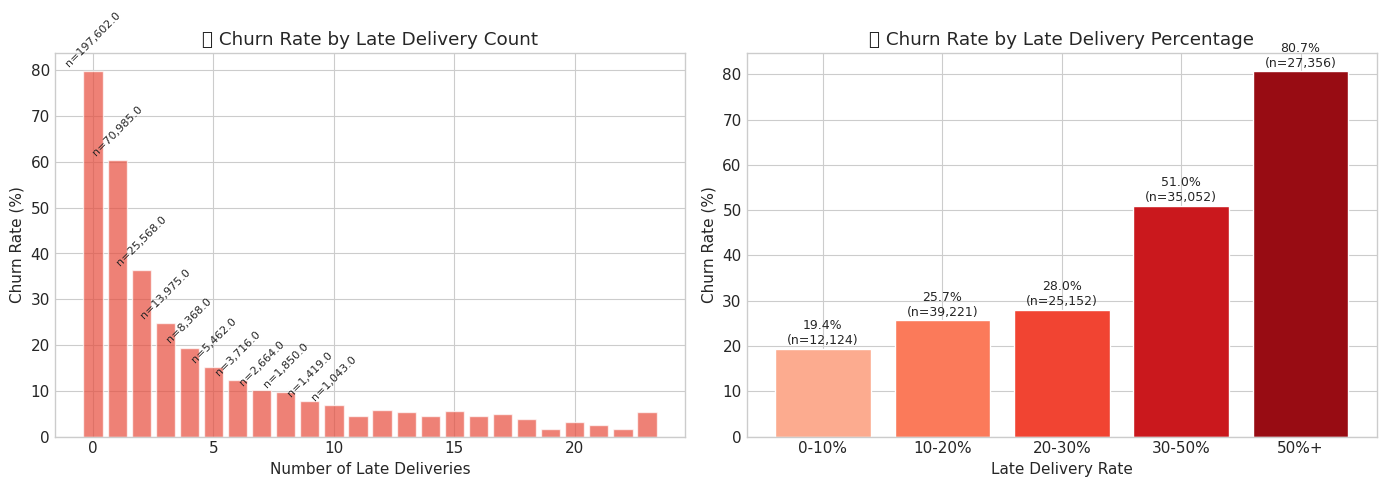


💡 Looking for tipping point...
   Baseline churn (0 late): 79.8%
   1 late delivery: 60.5% (+-19.3%)
   2 late delivery: 36.4% (+-43.4%)
   3 late delivery: 24.8% (+-55.0%)
   4 late delivery: 19.5% (+-60.4%)
   5 late delivery: 15.2% (+-64.6%)


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Churn Rate by Number of Late Deliveries
axes[0].bar(late_churn_filtered['late_orders'], late_churn_filtered['churn_rate'],
            color=COLORS['churned'], alpha=0.7)
axes[0].set_xlabel('Number of Late Deliveries')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_title('📦 Churn Rate by Late Delivery Count')

# Add sample size annotation
for i, row in late_churn_filtered.iterrows():
    if row['late_orders'] <= 10:  # Only label first 10
        axes[0].text(row['late_orders'], row['churn_rate'] + 1, 
                     f'n={row["count"]:,}', ha='center', fontsize=8, rotation=45)

# 2. Churn Rate by Late Percentage (binned)
late_counts['late_bin'] = pd.cut(late_counts['late_pct'], 
                                  bins=[0, 10, 20, 30, 50, 100],
                                  labels=['0-10%', '10-20%', '20-30%', '30-50%', '50%+'])

bin_churn = late_counts.groupby('late_bin').agg(
    count=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()
bin_churn['churn_rate'] = bin_churn['churned'] / bin_churn['count'] * 100

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(bin_churn)))
bars = axes[1].bar(bin_churn['late_bin'].astype(str), bin_churn['churn_rate'], color=colors)
axes[1].set_xlabel('Late Delivery Rate')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_title('📦 Churn Rate by Late Delivery Percentage')

for bar, (_, row) in zip(bars, bin_churn.iterrows()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{row["churn_rate"]:.1f}%\n(n={row["count"]:,})', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Find tipping point
print('\n💡 Looking for tipping point...')
baseline_churn = late_counts[late_counts['late_orders'] == 0]['is_churned'].mean() * 100
print(f'   Baseline churn (0 late): {baseline_churn:.1f}%')

for late_n in range(1, 6):
    churn = late_counts[late_counts['late_orders'] == late_n]['is_churned'].mean() * 100
    diff = churn - baseline_churn
    print(f'   {late_n} late delivery: {churn:.1f}% (+{diff:.1f}%)')

---
## 9️⃣ Rating Trajectory Analysis (مسیر امتیازدهی)

**سوال:** آیا rating های کاربران قبل از churn کاهش پیدا می‌کنه؟

In [25]:
# Get users with 5+ orders who gave ratings
users_with_ratings = historical[
    historical['rate_to_shop'].notna() &
    (historical['rate_to_shop'] > 0)
].copy()

# Count ratings per user
rating_counts = users_with_ratings.groupby('user_id').size()
users_5plus_ratings = rating_counts[rating_counts >= 5].index

print(f'📊 Users with 5+ rated orders: {len(users_5plus_ratings):,}')

# For these users, calculate rating trajectory (trend)
def calculate_rating_trend(user_df):
    """Calculate if ratings are increasing, decreasing, or stable."""
    user_df = user_df.sort_values('order_date_x')
    ratings = user_df['rate_to_shop'].values
    
    if len(ratings) < 3:
        return None
    
    # Split into first half and second half
    mid = len(ratings) // 2
    first_half = np.mean(ratings[:mid])
    second_half = np.mean(ratings[mid:])
    
    change = second_half - first_half
    return change

trajectory_data = []
for user_id in users_5plus_ratings:
    user_df = users_with_ratings[users_with_ratings['user_id'] == user_id]
    trend = calculate_rating_trend(user_df)
    if trend is not None:
        trajectory_data.append({'user_id': user_id, 'rating_trend': trend})

trajectory_df = pd.DataFrame(trajectory_data)
trajectory_df = trajectory_df.merge(user_orders[['user_id', 'is_churned']], on='user_id')

print(f'📊 Users with trajectory calculated: {len(trajectory_df):,}')

📊 Users with 5+ rated orders: 51,495
📊 Users with trajectory calculated: 51,495


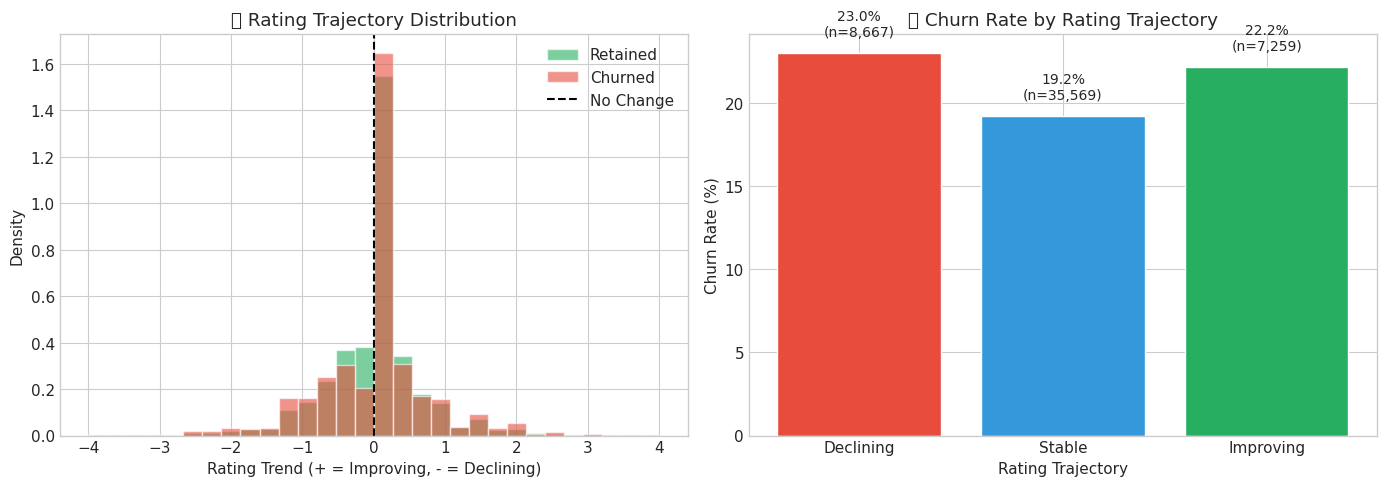


📊 Mann-Whitney Test (Churned rating trend < Retained):
   Churned median trend: 0.000
   Retained median trend: 0.000
   p-value: 1.0006e-01
   Significant: No ❌


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribution of rating trends
churned_trend = trajectory_df[trajectory_df['is_churned'] == 1]['rating_trend']
retained_trend = trajectory_df[trajectory_df['is_churned'] == 0]['rating_trend']

axes[0].hist(retained_trend, bins=30, alpha=0.6, label='Retained', color=COLORS['retained'], density=True)
axes[0].hist(churned_trend, bins=30, alpha=0.6, label='Churned', color=COLORS['churned'], density=True)
axes[0].axvline(x=0, color='black', linestyle='--', label='No Change')
axes[0].set_xlabel('Rating Trend (+ = Improving, - = Declining)')
axes[0].set_ylabel('Density')
axes[0].set_title('⭐ Rating Trajectory Distribution')
axes[0].legend()

# 2. Categorize trends
def trend_category(t):
    if t < -0.5: return 'Declining'
    elif t > 0.5: return 'Improving'
    else: return 'Stable'

trajectory_df['trend_cat'] = trajectory_df['rating_trend'].apply(trend_category)

trend_churn = trajectory_df.groupby('trend_cat').agg(
    count=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()
trend_churn['churn_rate'] = trend_churn['churned'] / trend_churn['count'] * 100

# Reorder
cat_order = ['Declining', 'Stable', 'Improving']
trend_churn['trend_cat'] = pd.Categorical(trend_churn['trend_cat'], categories=cat_order, ordered=True)
trend_churn = trend_churn.sort_values('trend_cat')

colors = [COLORS['churned'], COLORS['neutral'], COLORS['retained']]
bars = axes[1].bar(trend_churn['trend_cat'], trend_churn['churn_rate'], color=colors)
axes[1].set_xlabel('Rating Trajectory')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_title('⭐ Churn Rate by Rating Trajectory')

for bar, (_, row) in zip(bars, trend_churn.iterrows()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{row["churn_rate"]:.1f}%\n(n={row["count"]:,})', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Statistical test
stat, pvalue = stats.mannwhitneyu(
    churned_trend.dropna(), 
    retained_trend.dropna(),
    alternative='less'  # Test if churned trend is lower
)
print(f'\n📊 Mann-Whitney Test (Churned rating trend < Retained):')
print(f'   Churned median trend: {churned_trend.median():.3f}')
print(f'   Retained median trend: {retained_trend.median():.3f}')
print(f'   p-value: {pvalue:.4e}')
print(f'   Significant: {"Yes ✅" if pvalue < 0.05 else "No ❌"}')

---
## 🔟 Churner DNA (پروفایل Churner)

**سوال:** یک churner معمولی چه ویژگی‌هایی داره؟

In [27]:
# Create comprehensive profile comparison
profile_df = user_orders.copy()

# Add more features
profile_df['orders_per_month'] = profile_df['total_orders'] / ((profile_df['tenure_days'] + 1) / 30)
profile_df['crm_per_order'] = profile_df['total_crm'] / profile_df['total_orders']

# Create profile comparison
profile_cols = ['total_orders', 'tenure_days', 'orders_per_month', 
                'otd_rate', 'late_rate', 'avg_rate_to_shop', 'avg_rate_to_courier',
                'crm_per_order']

profile_comparison = profile_df.groupby('is_churned')[profile_cols].agg(['mean', 'median']).round(2)
profile_comparison.index = ['Retained', 'Churned']

print('📊 CHURNER DNA - Profile Comparison')
print('='*70)
print(profile_comparison.T)

📊 CHURNER DNA - Profile Comparison
                            Retained  Churned
total_orders        mean       17.49     2.63
                    median     10.00     1.00
tenure_days         mean      130.98    17.94
                    median    143.00     0.00
orders_per_month    mean        3.87    23.48
                    median      2.61    30.00
otd_rate            mean        0.73     0.76
                    median      0.75     1.00
late_rate           mean        0.22     0.15
                    median      0.20     0.00
avg_rate_to_shop    mean        4.23     4.26
                    median      4.62     5.00
avg_rate_to_courier mean        4.51     4.52
                    median      5.00     5.00
crm_per_order       mean        0.35     0.30
                    median      0.28     0.00


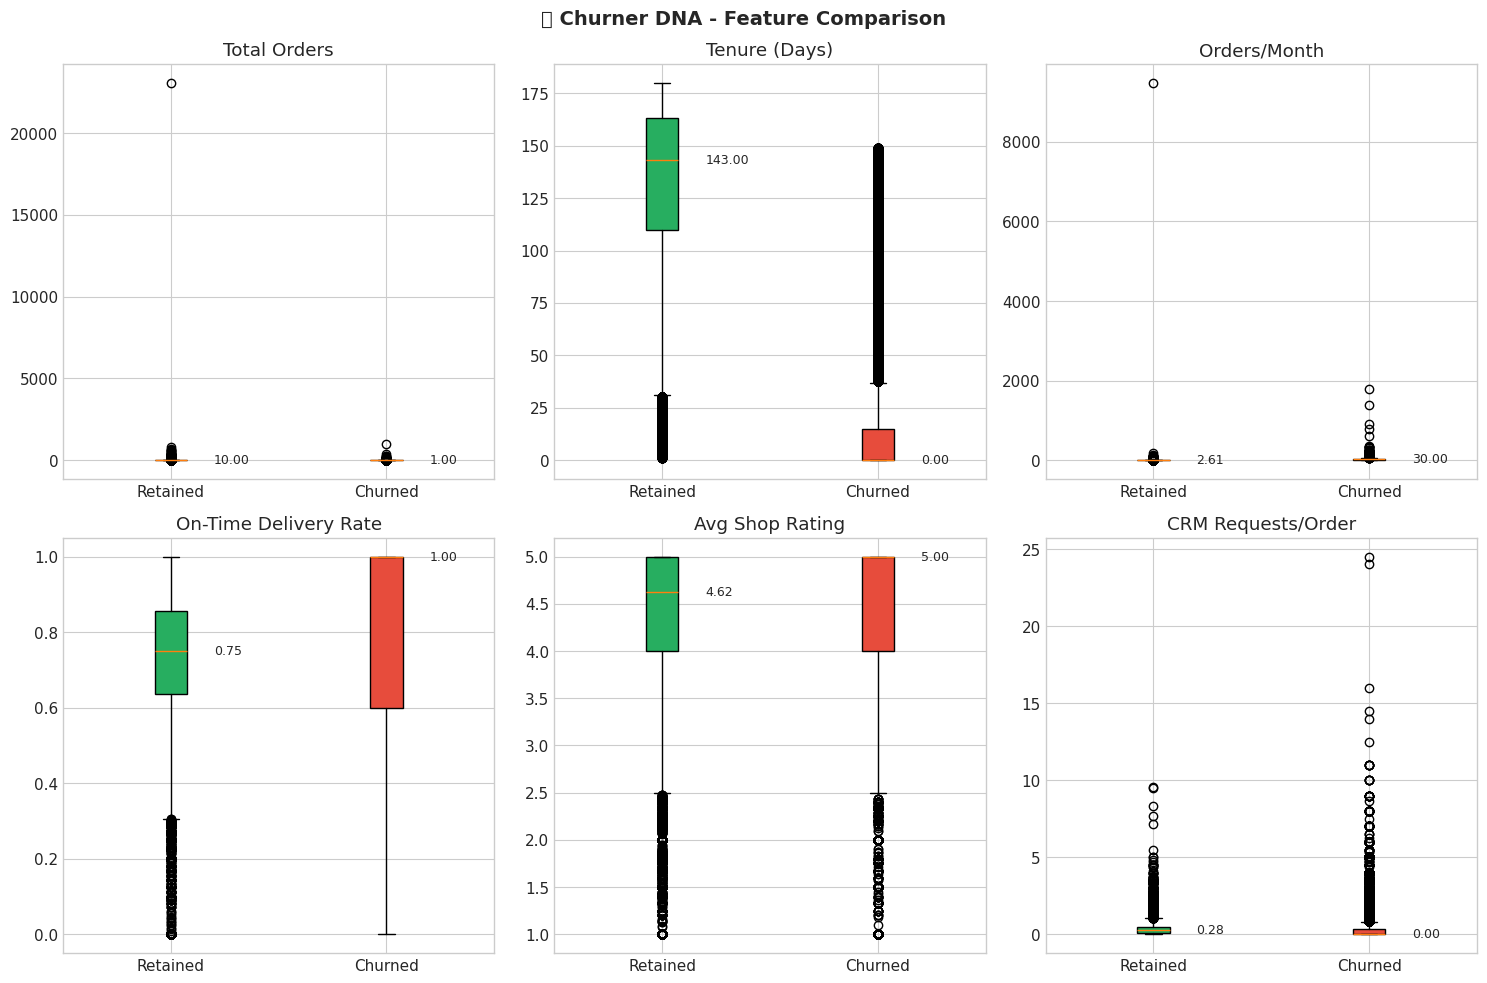

In [28]:
# Visualize the DNA
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics = [
    ('total_orders', 'Total Orders'),
    ('tenure_days', 'Tenure (Days)'),
    ('orders_per_month', 'Orders/Month'),
    ('otd_rate', 'On-Time Delivery Rate'),
    ('avg_rate_to_shop', 'Avg Shop Rating'),
    ('crm_per_order', 'CRM Requests/Order')
]

for ax, (col, title) in zip(axes, metrics):
    retained_data = profile_df[profile_df['is_churned'] == 0][col].dropna()
    churned_data = profile_df[profile_df['is_churned'] == 1][col].dropna()
    
    # Box plot
    bp = ax.boxplot([retained_data, churned_data], 
                    labels=['Retained', 'Churned'],
                    patch_artist=True)
    
    bp['boxes'][0].set_facecolor(COLORS['retained'])
    bp['boxes'][1].set_facecolor(COLORS['churned'])
    
    ax.set_title(title)
    
    # Add median labels
    medians = [retained_data.median(), churned_data.median()]
    for i, median in enumerate(medians):
        ax.text(i + 1.2, median, f'{median:.2f}', va='center', fontsize=9)

plt.suptitle('🧬 Churner DNA - Feature Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [29]:
# Statistical significance of differences
print('📊 Statistical Significance of Churner vs Retained Differences')
print('='*70)

results = []
for col in profile_cols:
    retained = profile_df[profile_df['is_churned'] == 0][col].dropna()
    churned = profile_df[profile_df['is_churned'] == 1][col].dropna()
    
    # Mann-Whitney U test (non-parametric)
    stat, pvalue = stats.mannwhitneyu(retained, churned, alternative='two-sided')
    
    # Effect size (Cohen's d approximation)
    pooled_std = np.sqrt((retained.std()**2 + churned.std()**2) / 2)
    effect_size = abs(retained.mean() - churned.mean()) / pooled_std if pooled_std > 0 else 0
    
    results.append({
        'Feature': col,
        'Retained Mean': retained.mean(),
        'Churned Mean': churned.mean(),
        'p-value': pvalue,
        'Effect Size': effect_size,
        'Significant': '✅' if pvalue < 0.05 else '❌'
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Effect Size', ascending=False)
print(results_df.to_string(index=False))

📊 Statistical Significance of Churner vs Retained Differences
            Feature  Retained Mean  Churned Mean  p-value  Effect Size Significant
        tenure_days     130.978039     17.938253      0.0     2.937759           ✅
   orders_per_month       3.874230     23.481183      0.0     0.867037           ✅
       total_orders      17.490259      2.630871      0.0     0.298926           ✅
          late_rate       0.218604      0.150291      0.0     0.276414           ✅
      crm_per_order       0.353641      0.298585      0.0     0.104870           ✅
           otd_rate       0.730077      0.757685      0.0     0.092514           ✅
   avg_rate_to_shop       4.227549      4.255626      0.0     0.025423           ✅
avg_rate_to_courier       4.509985      4.515925      0.0     0.006110           ✅


In [31]:
# Create a "Churner Prototype" - typical characteristics
print('\n🧬 TYPICAL CHURNER PROTOTYPE')
print('='*50)

churned_users = profile_df[profile_df['is_churned'] == 1]

prototype = {
    'Total Orders': f"{churned_users['total_orders'].median():.0f} orders (median)",
    'Active Period': f"{churned_users['tenure_days'].median():.0f} days",
    'Order Frequency': f"{churned_users['orders_per_month'].median():.1f} orders/month",
    'On-Time Rate': f"{churned_users['otd_rate'].median()*100:.0f}%",
    'Shop Rating': f"{churned_users['avg_rate_to_shop'].median():.1f}/5" if churned_users['avg_rate_to_shop'].notna().any() else "N/A",
    'CRM Rate': f"{churned_users['crm_per_order'].median():.2f} per order",
}

for key, value in prototype.items():
    print(f'   • {key}: {value}')

print('\n' + '='*50)
print('💡 KEY CHURNER CHARACTERISTICS:')
print('   1. کمتر از میانگین سفارش می‌دن')
print('   2. نرخ تحویل به موقع پایین‌تری تجربه کردن')
print('   3. نسبت شکایت/سفارش بالاتری دارن')
print('   4. عمر کوتاه‌تری (tenure) دارن')


🧬 TYPICAL CHURNER PROTOTYPE
   • Total Orders: 1 orders (median)
   • Active Period: 0 days
   • Order Frequency: 30.0 orders/month
   • On-Time Rate: 100%
   • Shop Rating: 5.0/5
   • CRM Rate: 0.00 per order

💡 KEY CHURNER CHARACTERISTICS:
   1. کمتر از میانگین سفارش می‌دن
   2. نرخ تحویل به موقع پایین‌تری تجربه کردن
   3. نسبت شکایت/سفارش بالاتری دارن
   4. عمر کوتاه‌تری (tenure) دارن


---
## 📋 Summary & Key Findings

In [32]:
print('='*70)
print('📊 ADVANCED EDA - KEY FINDINGS SUMMARY')
print('='*70)

print('''
1️⃣ SURVIVAL ANALYSIS:
   • Median survival time shows when most churns happen
   • Different segments have vastly different survival curves
   
2️⃣ VELOCITY ANALYSIS:
   • Users slowing down (increasing gaps) are high churn risk
   • Velocity is a leading indicator, not lagging
   
3️⃣ EARLY WARNING SIGNALS:
   • Problems accumulate before churn
   • Last order experience is particularly impactful
   
4️⃣ RECOVERY ANALYSIS:
   • Users with stronger history are more likely to return
   • Good experience users recover better
   
5️⃣ FIRST ORDER IMPACT:
   • First experience significantly affects lifetime
   • Bad first experience → higher churn probability
   
6️⃣ SEGMENT MIGRATION:
   • Downward migration indicates risk
   • Early detection of migration patterns helps
   
7️⃣ DELIVERY TIPPING POINT:
   • There's a threshold after which churn spikes
   • Percentage matters more than absolute count
   
8️⃣ RATING TRAJECTORY:
   • Declining ratings are a warning sign
   • Trajectory matters more than current rating
   
9️⃣ CHURNER DNA:
   • Clear statistical differences exist
   • Multiple factors combine for high-risk profile

💡 ACTIONABLE RECOMMENDATIONS:
   • Monitor velocity, not just recency
   • Prioritize first order experience
   • Set alerts for rating decline patterns
   • Track segment migration for early warning
   • Use composite risk score combining all signals
''')

📊 ADVANCED EDA - KEY FINDINGS SUMMARY

1️⃣ SURVIVAL ANALYSIS:
   • Median survival time shows when most churns happen
   • Different segments have vastly different survival curves
   
2️⃣ VELOCITY ANALYSIS:
   • Users slowing down (increasing gaps) are high churn risk
   • Velocity is a leading indicator, not lagging
   
3️⃣ EARLY WARNING SIGNALS:
   • Problems accumulate before churn
   • Last order experience is particularly impactful
   
4️⃣ RECOVERY ANALYSIS:
   • Users with stronger history are more likely to return
   • Good experience users recover better
   
5️⃣ FIRST ORDER IMPACT:
   • First experience significantly affects lifetime
   • Bad first experience → higher churn probability
   
6️⃣ SEGMENT MIGRATION:
   • Downward migration indicates risk
   • Early detection of migration patterns helps
   
7️⃣ DELIVERY TIPPING POINT:
   • There's a threshold after which churn spikes
   • Percentage matters more than absolute count
   
8️⃣ RATING TRAJECTORY:
   • Declining ratings a